# Plot Summary

- This notebook intends to investigate the plot summary of the [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) dataset.
- The notebook will look at the sentiments within plot summary of movies and how they correlate with a movie's revenue.

---
### Summary
- We analyze plot summary from three sentiments: positive, negative and violent words and analyze if their proportion in plot summary affects revenue.
- Movies with more negative plot have on average 43.5% more revenue than those with more positive plots.
- Movies with more violent plot are more likely to generate revenue since blockbuster movies have 25.4% higher violent word porportion than non-blockbuster movies.

---
### Data Processing

---
#### Loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns
import requests

In [2]:
# Read data and filter movies with revenue not null
df = pd.read_csv(
    "./data/movie.metadata.tsv",
    sep="\t",
    header=None,
    names=[
        "wiki_id",
        "fb_id",
        "name",
        "release_date",
        "revenue",
        "runtime",
        "languages",
        "countries",
        "genres",
    ],
)
df_meta = df[df["revenue"].notnull()]

In [3]:
# Read summary data and filter movies with summary not null
df_summary = pd.read_csv(
    "./data/plot_summaries.txt", sep="\t", header=None, names=["wiki_id", "summary"]
)
df_summary = df_summary[df_summary["summary"].notnull()]

In [4]:
# Merge metadata and summary data and filter for revenue and summary
df_merge = pd.merge(df_meta, df_summary, on=["wiki_id"], how="inner")
df_merge = df_merge[["wiki_id", "summary", "revenue"]]
df_merge.head(5)

,wiki_id,summary,revenue
0,975900,"Set in the second half of the 22nd century, th...",14010832.0
1,171005,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,10161099.0
2,77856,The film opens with Mary Poppins perched in a...,102272727.0
3,156558,A young 20-year-old named Jody lives with his...,29381649.0
4,261237,The film is a collision of three separate stor...,34331783.0


---
#### Positive / Negative / Violent Vocab Collection
We decide to examine if positivity, negativity and violence in plot will affect movie revenue.\
First, we collect vocabulary with positive, negative and violent connotation.

In [5]:
# Sentiment List
sentiment = ["positive", "negative", "violent"]

In [6]:
# collecting the positive words list

# requesting the url
r = requests.get("https://ptrckprry.com/course/ssd/data/positive-words.txt")

# extracting and decoding the content from the request
text = r.content.decode("us-ascii")

# extracting the text containing the positive words
pos_text = text.split("\n\n")

# converting the text into a list
pos_list = pos_text[1].split("\n")

In [7]:
# collecting the neagative words list

# requesting the url
r = requests.get("https://ptrckprry.com/course/ssd/data/negative-words.txt")

# extracting and decoding the content from the request
text = r.content.decode("iso-8859-1")

# extracting the text containing the negative words
neg_text = text.split("\n\n")

# converting the text into a list
neg_list = neg_text[1].split("\n")

In [8]:
# collecting the violence words list
# source: https://myvocabulary.com/word-list/violence-vocabulary/

# Read from txt file
violent_file = open("./data/violent_word_list.txt", "r")
violent_words = violent_file.read()

# Split into list
vio_list = violent_words.split(", ")

# Map every word into lower case
vio_list = list(map(lambda x: x.lower(), vio_list))

---
#### Positive / Negative / Violent proportion in summary
We calculate the proportion of words with positive / negative / violent connotation out of all words in movie summary.

In [9]:
# creating a function to calculate proportion in summary
def check_summary(summary, list_):
    """
    Count what proportion of words from a list the summary contains

    Parameters
    ----------
    summary: string
        The summary you desire to check
    list_: array
        The list to do look up in

    Returns
    -------
    int
        Proportion of words contained from given list (0-1)
    """
    cnt = 0
    summary_lst = summary.lower().split()
    for word in summary_lst:
        if word in list_:
            cnt += 1
    return cnt / len(summary_lst)

In [10]:
# adding column for positive sentiment
df_merge["positive"] = df_merge["summary"].apply(lambda x: check_summary(x, pos_list))

# adding a columns for negative sentiment
df_merge["negative"] = df_merge["summary"].apply(lambda x: check_summary(x, neg_list))

# adding a columns for violent sentiment
df_merge["violent"] = df_merge["summary"].apply(lambda x: check_summary(x, vio_list))

In [11]:
df_merge.head(2)

,wiki_id,summary,revenue,positive,negative,violent
0,975900,"Set in the second half of the 22nd century, th...",14010832.0,0.005602,0.044818,0.033613
1,171005,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,10161099.0,0.014925,0.014925,0.000000


---
### Regression & Scatterplot

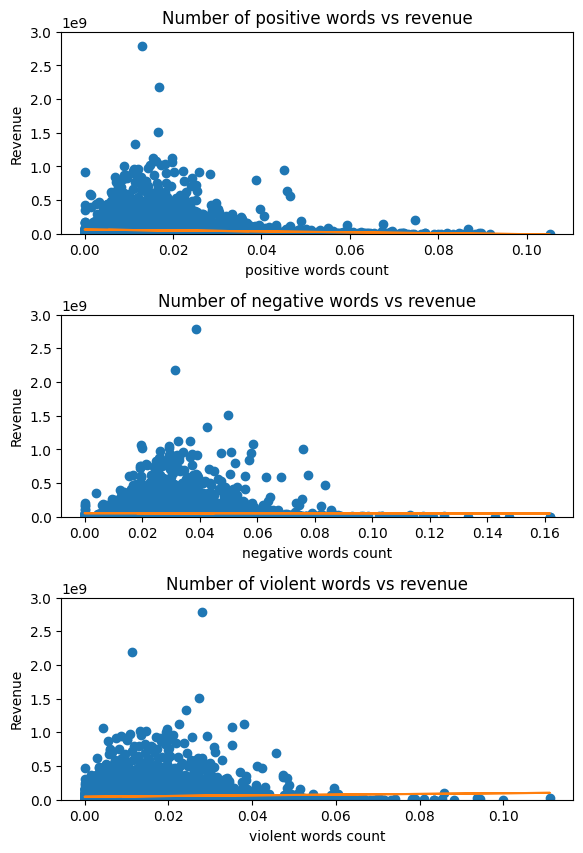

In [12]:
fig, ax = plt.subplots(3, 1)

# sentiment to ax position mapping
sen2ax = {"positive": ax[0], "negative": ax[1], "violent": ax[2]}

# Plot for each sentiment: positive, negative, violent
for s in sentiment:
    ax = sen2ax[s]
    ax.plot(df_merge[s], df_merge["revenue"], "o")

    # obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(df_merge[s], df_merge["revenue"], 1)
    # add linear regression line to scatterplot
    ax.plot(df_merge[s], m * df_merge[s] + b)

    ax.set_title("Number of " + s + " words vs revenue")
    ax.set_xlabel(s + " words count")
    ax.set_ylabel("Revenue")
    ax.set_ylim(0, 3000000000)

# Combine all the operations and display
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1.7, wspace=0.4, hspace=0.4)
plt.show()

# sns.lmplot(x='positive', y='revenue', data=df_merge)

In [13]:
# Regression analysis for positive word proportion vs revenue
positive_revenue_model = smf.ols("revenue ~ positive", data=df_merge).fit()
positive_revenue_model_summary = positive_revenue_model.summary()
positive_revenue_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     35.97
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           2.10e-09
Time:                        02:15:56   Log-Likelihood:            -1.5168e+05
No. Observations:                7587   AIC:                         3.034e+05
Df Residuals:                    7585   BIC:                         3.034e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.361e+07   2.39e+06     26.660      0.000    5.89e+07    6.83e+07
positive   -6.802e+08   1.13e+08     -5.997      0.000   -9.03e+08   -4.58e+08
==============================================================================
Omnibus:                     9295.825   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1985010.624
Skew:                           6.453   Prob(JB):                         0.00
Kurtosis:                      81.183   Cond. No.                         84.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# Regression analysis for negative word proportion vs revenue
negative_revenue_model = smf.ols("revenue ~ negative", data=df_merge).fit()
negative_revenue_model_summary = negative_revenue_model.summary()
negative_revenue_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.07444
Date:                Tue, 15 Nov 2022   Prob (F-statistic):              0.785
Time:                        02:15:56   Log-Likelihood:            -1.5170e+05
No. Observations:                7587   AIC:                         3.034e+05
Df Residuals:                    7585   BIC:                         3.034e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.251e+07   3.07e+06     17.104      0.000    4.65e+07    5.85e+07
negative   -2.422e+07   8.88e+07     -0.273      0.785   -1.98e+08     1.5e+08
==============================================================================
Omnibus:                     9287.283   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1966152.319
Skew:                           6.445   Prob(JB):                         0.00
Kurtosis:                      80.803   Cond. No.                         66.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# Regression analysis for violent word proportion vs revenue
violence_revenue_model = smf.ols("revenue ~ violent", data=df_merge).fit()
violence_revenue_model_summary = violence_revenue_model.summary()
violence_revenue_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     19.49
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           1.03e-05
Time:                        02:15:56   Log-Likelihood:            -1.5169e+05
No. Observations:                7587   AIC:                         3.034e+05
Df Residuals:                    7585   BIC:                         3.034e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.465e+07   2.09e+06     21.312      0.000    4.05e+07    4.88e+07
violent     5.177e+08   1.17e+08      4.414      0.000    2.88e+08    7.48e+08
==============================================================================
Omnibus:                     9266.148   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1949858.482
Skew:                           6.420   Prob(JB):                         0.00
Kurtosis:                      80.480   Cond. No.                         87.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Comment
- From the scatterplot, we see that there is a slight negative linear relationship between positive word proportion and revenue. There is also a slight negative linear relationship between negative word proportion and revenue. In contrast, there is a slight positive linear relationship between violent word proportion and revenue. 
- However from previous regression analysis, the R squared value (0.005 - positive, 0.000 - negative, 0.003 - violent) is too small to justify the dependency between all sentiments and revenue. 
- We see a opposing relationship between positive and negative and we will discover if more positive plot or more negative plot can boost the revenue in the following section.

---
### Difference in revenues between movies with more positive and more negative plot
We will analyze if plots with more positive word proportions will generate more revenues than those with more negative word proportions. 

In [16]:
# Filter for movies that have higher proportion of positive words than negative words
df_pos_majority = df_merge[df_merge["positive"] > df_merge["negative"]]

# Filter for movies that higher proportion of negative words than positive words
df_neg_majority = df_merge[df_merge["negative"] > df_merge["positive"]]

In [17]:
# independent t-test
stats.ttest_ind(
    a=df_pos_majority["revenue"], b=df_neg_majority["revenue"], equal_var=False
)

Ttest_indResult(statistic=-10.24587961073901, pvalue=2.544081884703153e-24)

In [18]:
# calculate mean difference
mean_diff = df_pos_majority["revenue"].mean() - df_neg_majority["revenue"].mean()

# print the mean difference
print(f"The mean difference in revenue is: {mean_diff}")

The mean difference in revenue is: -25191660.368726265


In [19]:
# calculating the percentage difference in revenue between the mean and negative
diff_percent = mean_diff / df_neg_majority["revenue"].mean()

# printing the results
diff_percent

-0.4350950933633603

#### Comment
- The independent t-test gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.
- Further, the mean difference tells us that movies with more positive plot generally has less revenue than movies with more negative plot.
- We can conclude that movies with more negative plot are more successful, as movies with more negative plot have 43.5% more revenue than movies with more positive plot.

---
### Difference in sentiment proportion between blockbuster vs non-blockbuster
We define **blockbusters** as movies with revenue >= 400 million USD\
and **non-blockbusters** as movies with revenue < 400 million USD.

In [20]:
# Filter blockbuster movies
df_bb = df_merge[df_merge["revenue"] >= 400000000]

# Filter non-blockbuster movies
df_non_bb = df_merge[df_merge["revenue"] < 400000000]

In [21]:
# For each sentiment
for s in sentiment:
    # independent t-test
    print(stats.ttest_ind(a=df_bb[s], b=df_non_bb[s], equal_var=False))

    # calculate mean difference
    mean_diff = df_bb[s].mean() - df_non_bb[s].mean()

    # print the mean difference
    print(f"The mean difference in proportion of {s} words in summary is: {mean_diff}")

    # calculating the percentage difference between the mean and non-blockbuster
    diff_percent = mean_diff / df_non_bb[s].mean()

    # printing the results
    print(
        f"The percentage difference in porportion of {s} words in summary between mean and non-blockbuster is: {diff_percent * 100}%\n"
    )

Ttest_indResult(statistic=-4.088596105905725, pvalue=6.758486063402038e-05)
The mean difference in proportion of positive words in summary is: -0.002658821287623174
The percentage difference in porportion of positive words in summary between mean and non-blockbuster is: -15.212555769036173%

Ttest_indResult(statistic=2.1363119989190644, pvalue=0.034169082182729474)
The mean difference in proportion of negative words in summary is: 0.0021549510884681794
The percentage difference in porportion of negative words in summary between mean and non-blockbuster is: 6.9358037646179%

Ttest_indResult(statistic=4.693535695037376, pvalue=5.7033862143981695e-06)
The mean difference in proportion of violent words in summary is: 0.0034737067714620262
The percentage difference in porportion of violent words in summary between mean and non-blockbuster is: 25.408360120249878%



#### positive
- The independent t-test for positive words gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
- Further, the mean difference tells us that blockbuster movies generally has smaller positive word proportion in summary than non-blockbuster.  
- We can conclude that less positive plot components are more successful, as blockbuster movies have 15.21% less positive word usage than non-blockbuster movies. 

#### negative
- The independent t-test for negative words gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
- Further, the mean difference tells us that blockbuster movies generally has higher negative word proportion in summary than non-blockbuster.  
- We can conclude that more negative plot components are more successful, as blockbuster movies have 6.93% more negative word proportion than non-blockbuster movies. 

#### violent
- The independent t-test for violent words gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
- Further, the mean difference tells us that blockbuster movies generally has higher violent word proportion in summary than non-blockbuster.  
- We can conclude that more violent plot components are more successful as blockbuster movies have 25.4% higher violent word porportion than non-blockbuster movies. 